In [3]:
# Pip imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import stan

try:
    import arviz as az
except ImportError as err:
    print("Please, install arviz for easy visualization of Stan models.")

import nest_asyncio
nest_asyncio.apply()

import pandas as pd

/home/krupkaa/anaconda3/envs/cognitive/lib/python3.12/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [34]:
stan_code = """

data {
    int<lower=1> N;
    matrix[N, 3] x;
    vector[N] y;
}

parameters {
    real<lower=0> sigma;
    real alpha;
    vector[3] beta;
}

model {
    sigma ~ inv_gamma(0.3, 0.6);
    alpha ~ normal(0, 5);
    beta ~ normal(0,1);

    for (n in 1:N) {
        y[n] ~ normal(alpha + beta' * (x[n]'), sigma);
    }
}

"""

In [69]:
# Read in the file
insurance_data = pd.read_csv("insurance.csv")

key_param_df = insurance_data[['age', 'bmi', 'children']].astype(np.float64)

# Standardize the data in these columns

for col in key_param_df:
    key_param_df[col] = (key_param_df[col] - key_param_df[col].mean())/(key_param_df[col].std())


print (key_param_df)

           age       bmi  children
0    -1.438227 -0.453151 -0.908274
1    -1.509401  0.509431 -0.078738
2    -0.797655  0.383164  1.580335
3    -0.441782 -1.305043 -0.908274
4    -0.512957 -0.292447 -0.908274
...        ...       ...       ...
1333  0.768185  0.050278  1.580335
1334 -1.509401  0.206062 -0.908274
1335 -1.509401  1.014499 -0.908274
1336 -1.295877 -0.797515 -0.908274
1337  1.551106 -0.261290 -0.908274

[1338 rows x 3 columns]


In [70]:
data_dict = {
    'N': insurance_data.shape[0],
    #'x': np.ndarray(key_param_df.values, dtype=float)
    'x': key_param_df.values,
    'y': insurance_data['charges'].values
}

model = stan.build(stan_code, data=data_dict)

Building...



Building: found in cache, done.

In [68]:
fit = model.sample(num_chains=4, num_samples=100, num_warmup=50)

Sampling:   0%
Sampling:   0% (1/600)
Sampling:   0% (2/600)
Sampling:   0% (3/600)
Sampling:   1% (4/600)
Sampling:   9% (54/600)
Sampling:  17% (104/600)
Sampling:  26% (154/600)
Sampling:  34% (204/600)
Sampling:  50% (303/600)
Sampling:  67% (402/600)
Sampling:  84% (501/600)
Sampling: 100% (600/600)
Sampling: 100% (600/600), done.
Messages received during sampling:
  Gradient evaluation took 0.00257 seconds
  1000 transitions using 10 leapfrog steps per transition would take 25.7 seconds.
  Adjust your expectations accordingly!
           three stages of adaptation as currently configured.
           Reducing each adaptation stage to 15%/75%/10% of
           the given number of warmup iterations:
             init_buffer = 7
             adapt_window = 38
             term_buffer = 5
  Gradient evaluation took 0.001593 seconds
  1000 transitions using 10 leapfrog steps per transition would take 15.93 seconds.
  Adjust your expectations accordingly!
           three stages of adap

In [71]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,17888.546,352.791,17219.215,18531.220,18.437,18.418,374.0,269.0,1.00
alpha,1.248,5.265,-8.105,10.532,0.991,0.382,29.0,40.0,1.11
beta[0],2.312,0.856,0.754,3.844,0.043,0.046,388.0,342.0,1.01
beta[1],1.791,0.973,-0.167,3.515,0.053,0.051,345.0,260.0,1.00
beta[2],0.077,0.986,-1.509,2.139,0.047,0.050,443.0,262.0,1.01


array([[<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n0'}>],
       [<Axes: title={'center': 'beta\n1'}>,
        <Axes: title={'center': 'beta\n1'}>],
       [<Axes: title={'center': 'beta\n2'}>,
        <Axes: title={'center': 'beta\n2'}>]], dtype=object)

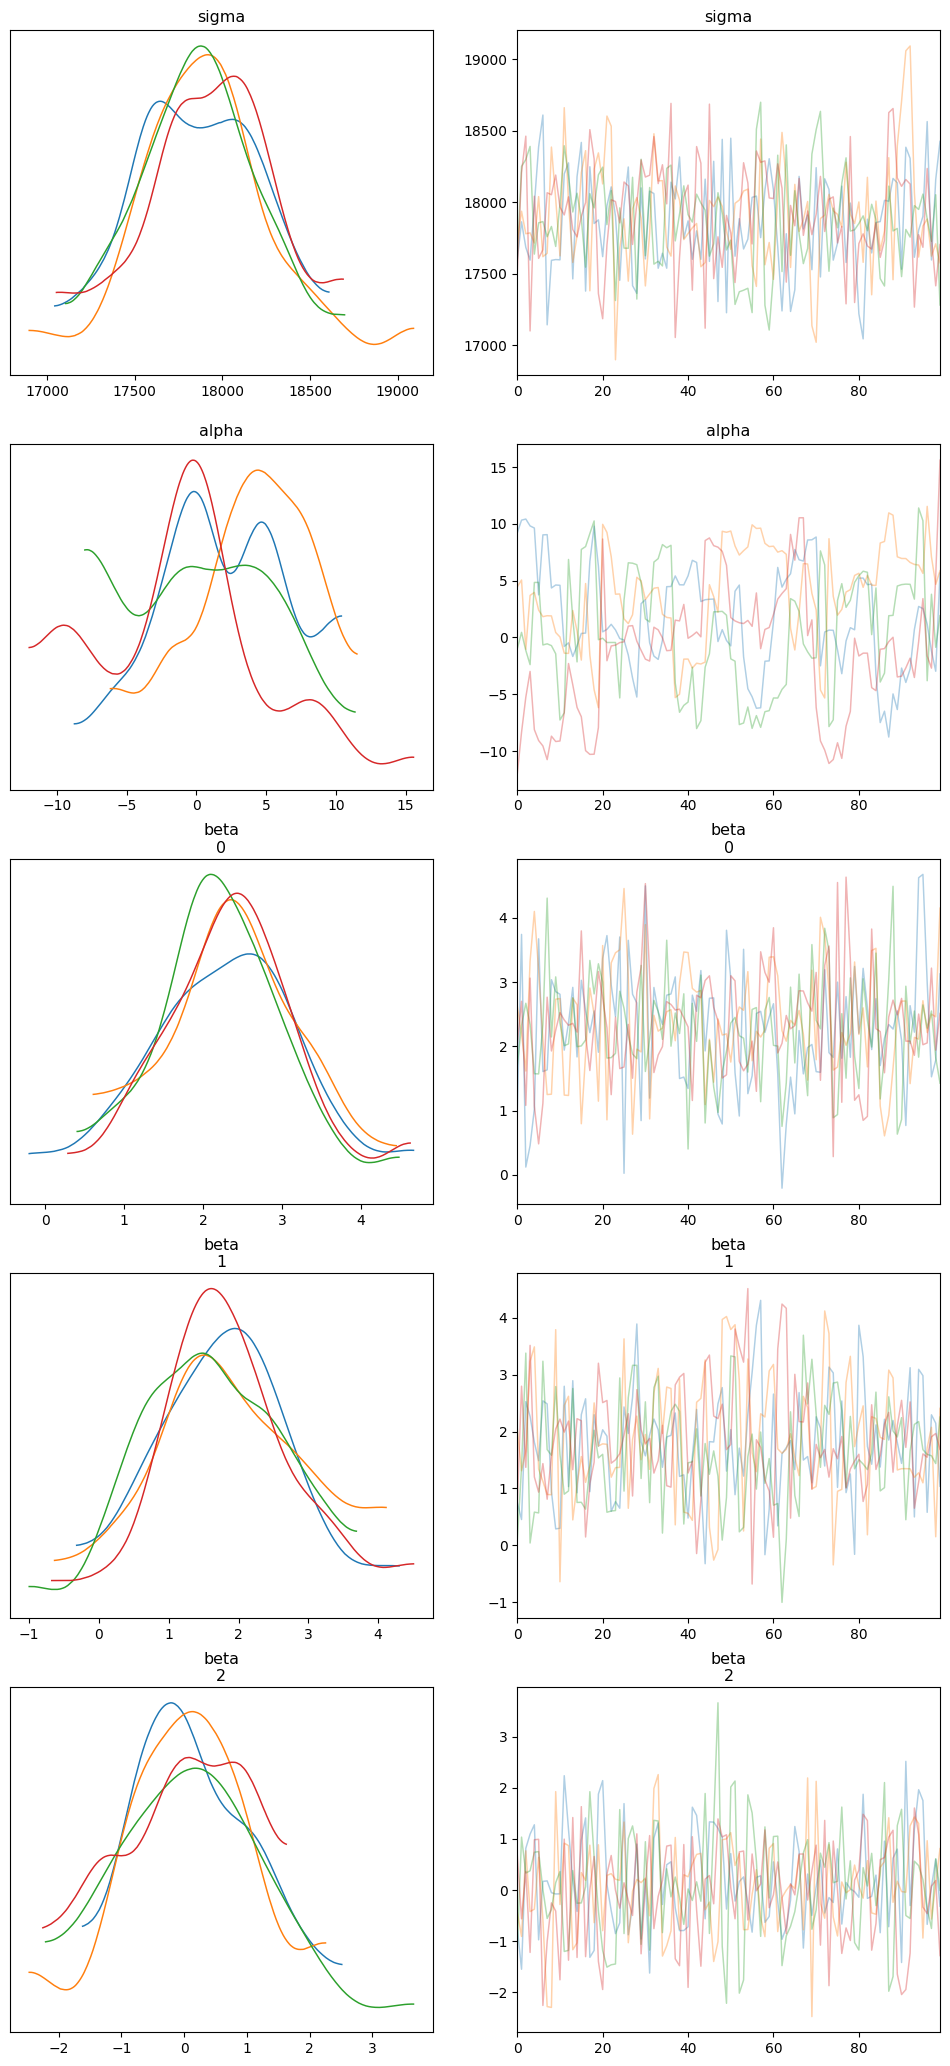

In [72]:
az.plot_trace(fit, compact=False, figsize=(12, 26))

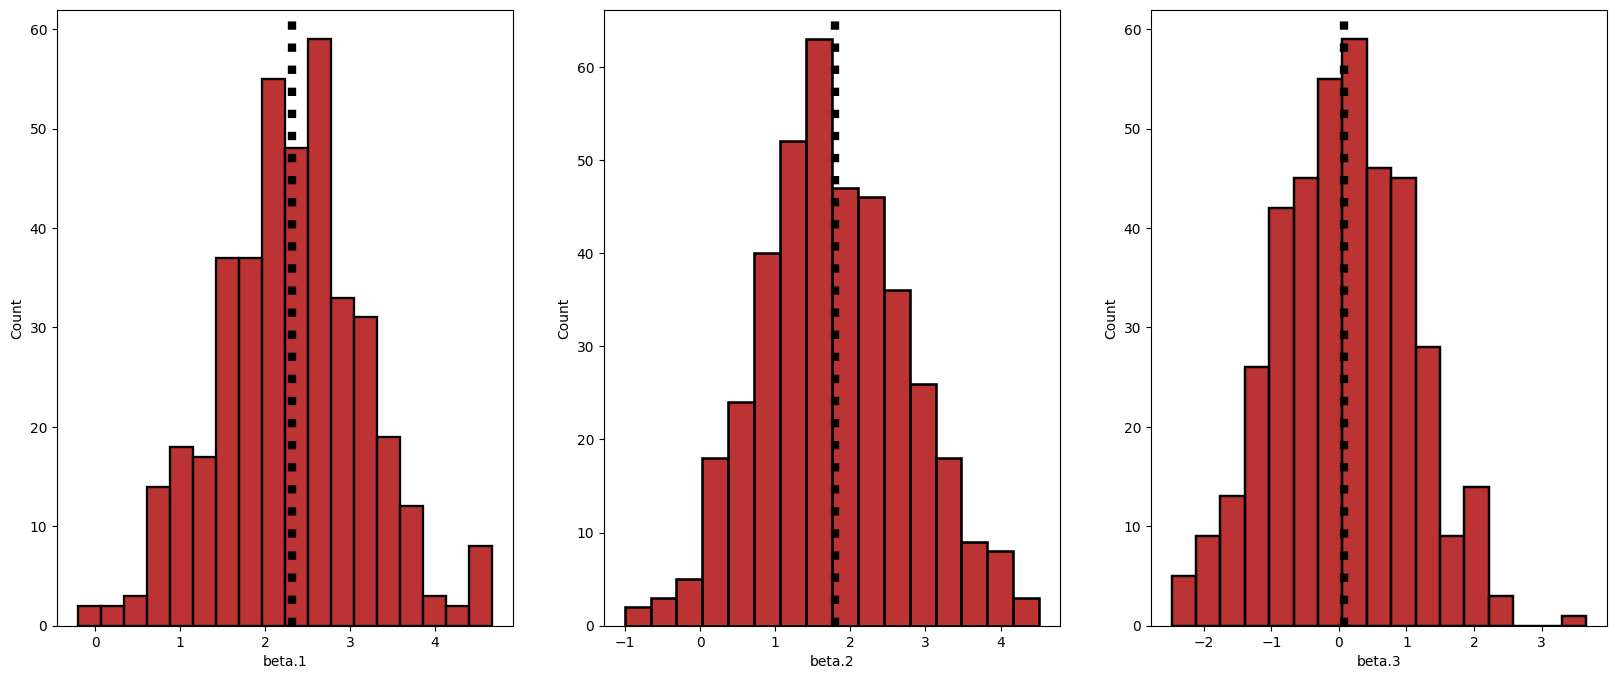

In [80]:
results_frame = fit.to_frame()

f, ax = plt.subplots(1, 3, figsize=(20, 8))

sns.histplot(results_frame, x='beta.1', ax = ax[0], color='#AA0000', alpha=0.8, lw=2)
sns.histplot(results_frame, x='beta.2', ax = ax[1], color='#AA0000', alpha=0.8, lw=2)
sns.histplot(results_frame, x='beta.3', ax = ax[2], color='#AA0000', alpha=0.8, lw=2)

ax[0].axvline(np.mean(results_frame['beta.1']), color='black', linestyle='dotted', lw=6)
ax[1].axvline(np.mean(results_frame['beta.2']), color='black', linestyle='dotted', lw=6)
ax[2].axvline(np.mean(results_frame['beta.3']), color='black', linestyle='dotted', lw=6)